In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier
#from xgboost import plot_tree
from scipy.stats import ttest_rel


from sklearn.neural_network import MLPClassifier


np.set_printoptions(suppress=True)
%config InlineBackend.figure_format = 'retina'

In [48]:
df = pd.read_excel('~/Downloads/Uber_Data.xlsx', sheet_name='Switchbacks')
df['total_trips'] = df['trips_pool'] + df['trips_express_pool']

In [49]:
df.head()

,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express_pool,rider_cancellations,total_driver_payout,total_matches,total_double_matches,total_trips
0,Boston,2018-02-19 07:00:00,2 mins,False,True,1415,3245,256,34458.411634,3372,1476,4660
1,Boston,2018-02-19 09:40:00,5 mins,True,False,1461,2363,203,29764.349821,2288,1275,3824
2,Boston,2018-02-19 12:20:00,2 mins,False,False,1362,2184,118,27437.367363,2283,962,3546
3,Boston,2018-02-19 15:00:00,5 mins,True,True,1984,3584,355,44995.452993,4035,2021,5568
4,Boston,2018-02-19 17:40:00,2 mins,False,False,1371,2580,181,27583.955295,2200,979,3951


In [50]:
df.dtypes

city_id                         object
period_start            datetime64[ns]
wait_time                       object
treat                             bool
commute                           bool
trips_pool                       int64
trips_express_pool               int64
rider_cancellations              int64
total_driver_payout            float64
total_matches                    int64
total_double_matches             int64
total_trips                      int64
dtype: object

In [51]:
df.treat.value_counts

<bound method IndexOpsMixin.value_counts of 0      False
1       True
2      False
3       True
4      False
       ...  
121     True
122    False
123     True
124    False
125     True
Name: treat, Length: 126, dtype: bool>

In [52]:
df[df.wait_time == '2 mins'].describe()

,period_start,trips_pool,trips_express_pool,rider_cancellations,total_driver_payout,total_matches,total_double_matches,total_trips
count,63,63.00000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,2018-02-26 04:20:00.000001024,1355.31746,2611.666667,165.349206,29291.238922,2633.206349,1287.158730,3966.984127
min,2018-02-19 07:00:00,771.00000,1845.000000,95.000000,22153.188782,1885.000000,735.000000,3002.000000
25%,2018-02-22 17:40:00,1201.50000,2264.500000,132.500000,25105.857069,2206.500000,1026.500000,3569.500000
50%,2018-02-26 04:20:00,1362.00000,2496.000000,160.000000,28041.728438,2541.000000,1211.000000,3809.000000
75%,2018-03-01 15:00:00,1486.00000,2757.500000,178.500000,31438.036593,2737.500000,1478.000000,4272.500000
max,2018-03-05 01:40:00,1957.00000,4507.000000,350.000000,48600.421964,5005.000000,2533.000000,6009.000000
std,NaN,234.43548,516.708285,46.536201,5675.727426,626.927612,373.453335,604.801287


In [53]:
df[df.wait_time == '5 mins'].describe()

,period_start,trips_pool,trips_express_pool,rider_cancellations,total_driver_payout,total_matches,total_double_matches,total_trips
count,63,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,2018-02-26 07:00:00.000001024,1460.698413,2419.380952,190.126984,27183.202390,2438.301587,1357.730159,3880.079365
min,2018-02-19 09:40:00,829.000000,1638.000000,125.000000,18769.992989,1588.000000,728.000000,3046.000000
25%,2018-02-22 20:20:00,1298.000000,2085.500000,156.500000,23937.146419,2105.000000,1137.000000,3477.000000
50%,2018-02-26 07:00:00,1435.000000,2361.000000,173.000000,26017.526022,2299.000000,1322.000000,3784.000000
75%,2018-03-01 17:40:00,1632.500000,2536.500000,195.000000,28995.230532,2552.500000,1485.000000,4205.500000
max,2018-03-05 04:20:00,2241.000000,3946.000000,355.000000,44995.452993,4203.000000,2739.000000,5568.000000
std,NaN,271.156343,462.190906,53.825133,5043.154791,576.111258,324.710402,542.003193


In [54]:
c = df[df.wait_time == '2 mins']
t = df[df.wait_time == '5 mins']

In [55]:
def calc_confidence_interval(df, field):
    m = df[field].mean()
    s = df[field].std()
    print(f"CI: {m - 1.96*s} to {m + 1.96*s}")

In [56]:
calc_confidence_interval(c, 'rider_cancellations')

CI: 74.1382519671632 to 256.56016073124954


In [57]:
calc_confidence_interval(t, 'rider_cancellations')

CI: 84.62972412417479 to 295.62424412979345


In [58]:
calc_confidence_interval(c, 'total_trips')

CI: 2781.5736048508747 to 5152.394649117379


In [59]:
calc_confidence_interval(t, 'total_trips')

CI: 2817.753106583603 to 4942.405623575128


<Axes: title={'center': 'rider_cancellations'}, xlabel='wait_time'>

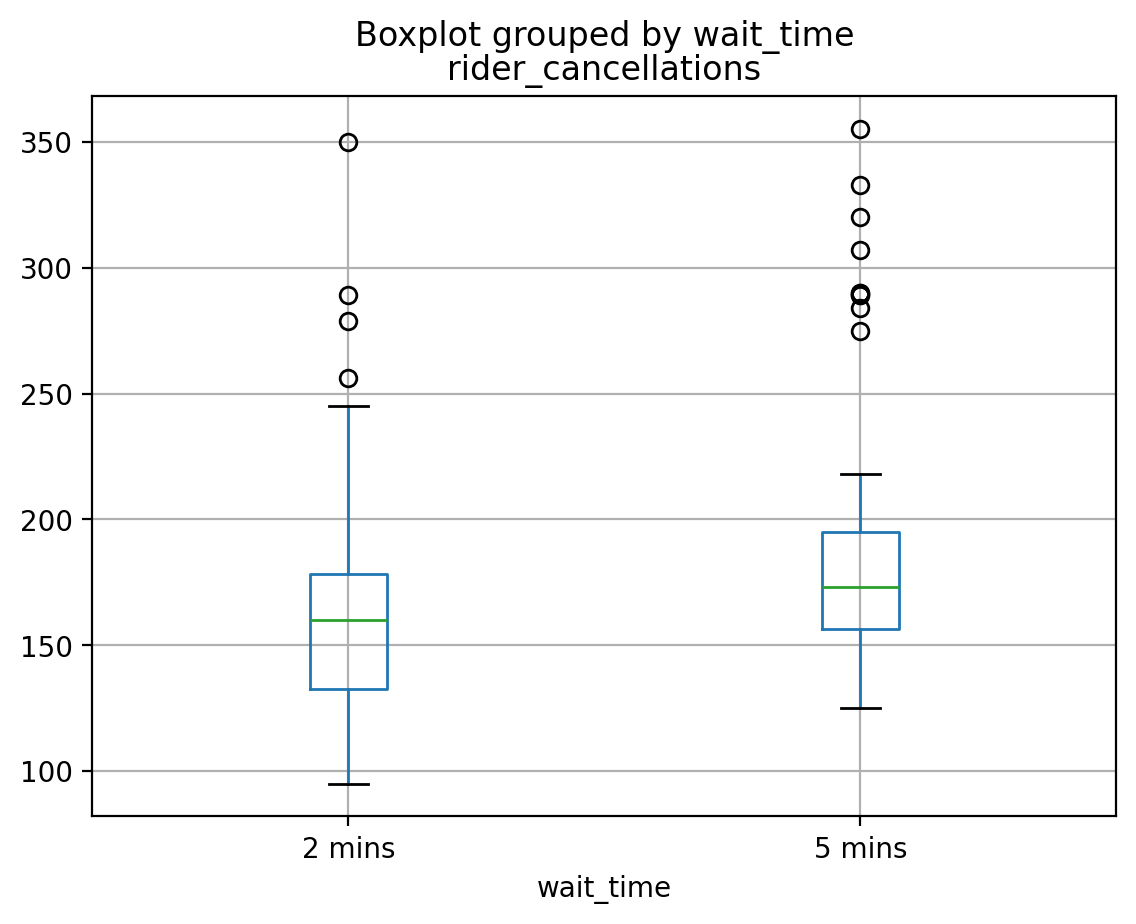

In [61]:
df.boxplot(column='rider_cancellations', by='wait_time')

<Axes: title={'center': 'rider_cancellations'}, xlabel='[wait_time, commute]'>

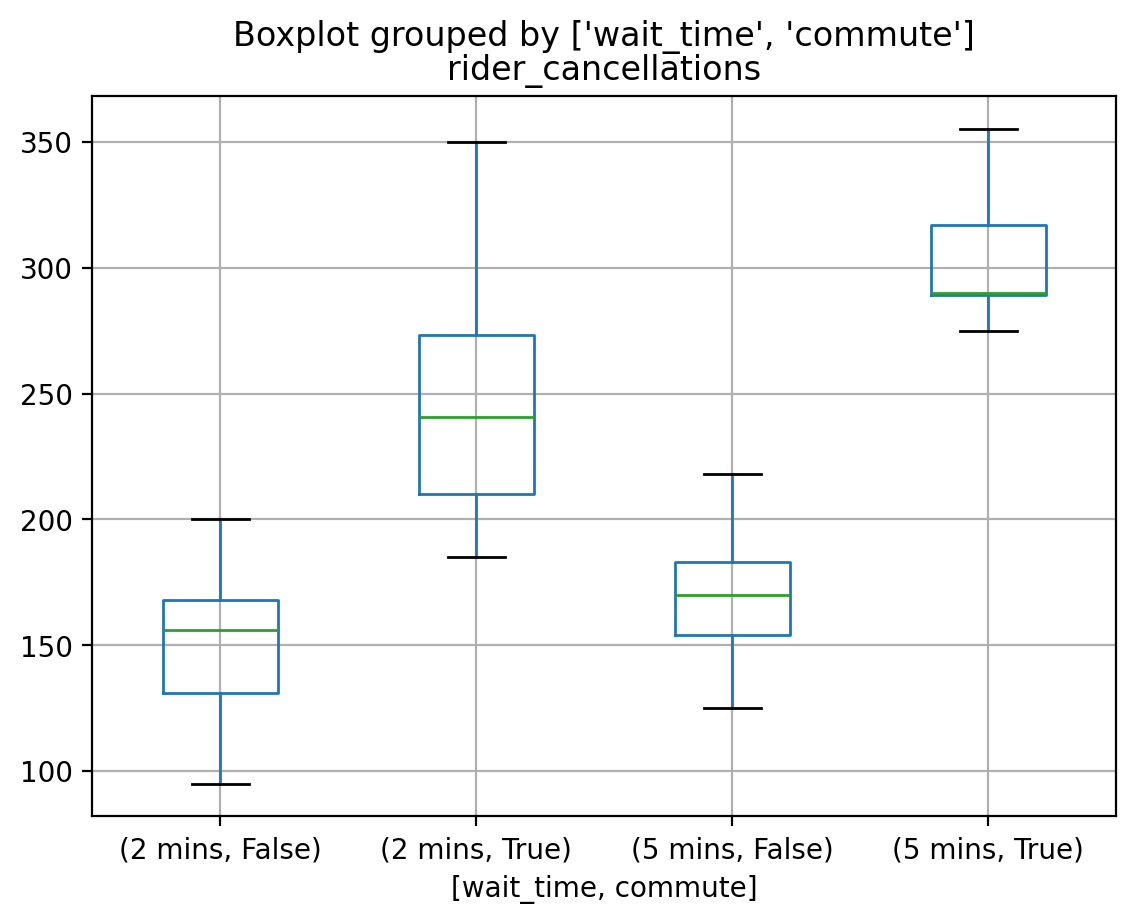

In [71]:
df.boxplot(column='rider_cancellations', by=['wait_time','commute'])

In [67]:
t_stat, p_value = ttest_rel(c['rider_cancellations'], t['rider_cancellations'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -2.557678380799446, P-value: 0.012996562959602264


<Axes: title={'center': 'total_driver_payout'}, xlabel='wait_time'>

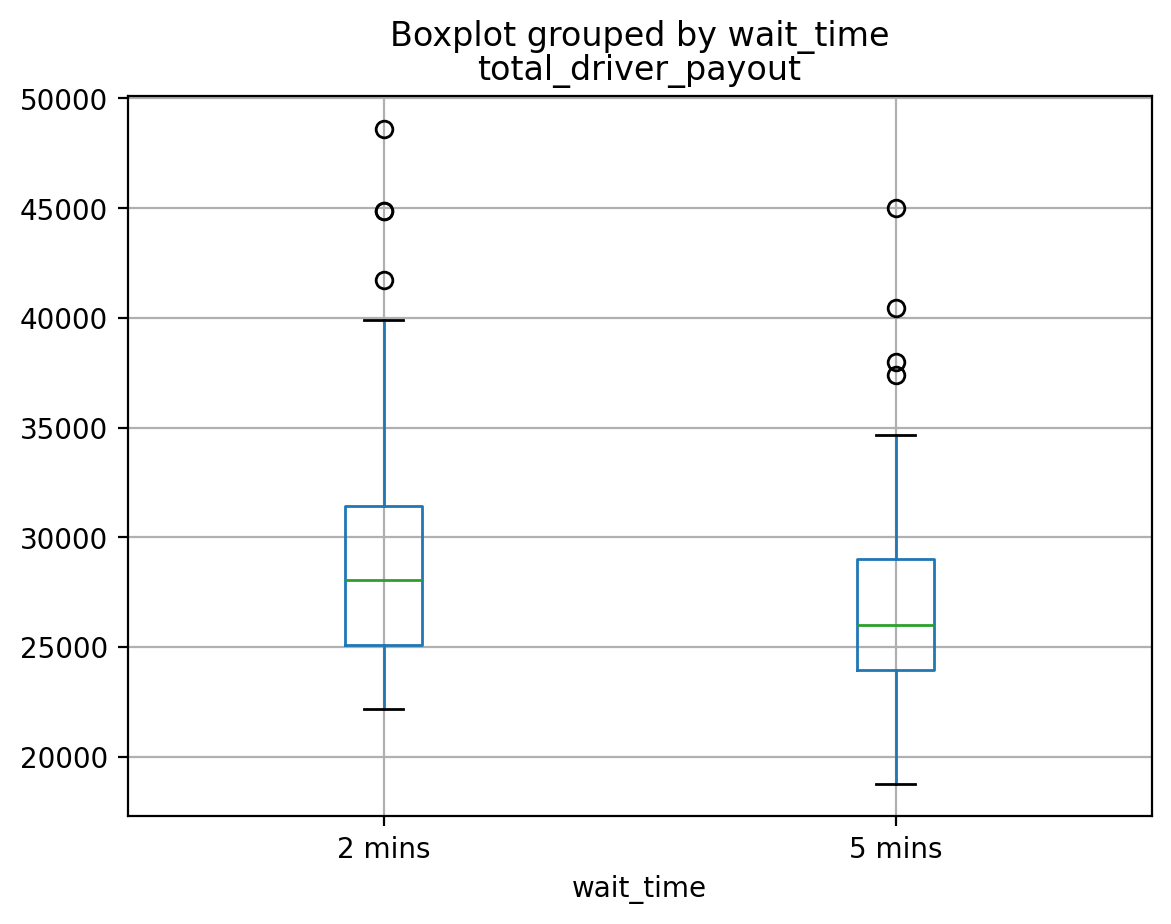

In [62]:
df.boxplot(column='total_driver_payout', by='wait_time')

<Axes: title={'center': 'total_driver_payout'}, xlabel='[wait_time, commute]'>

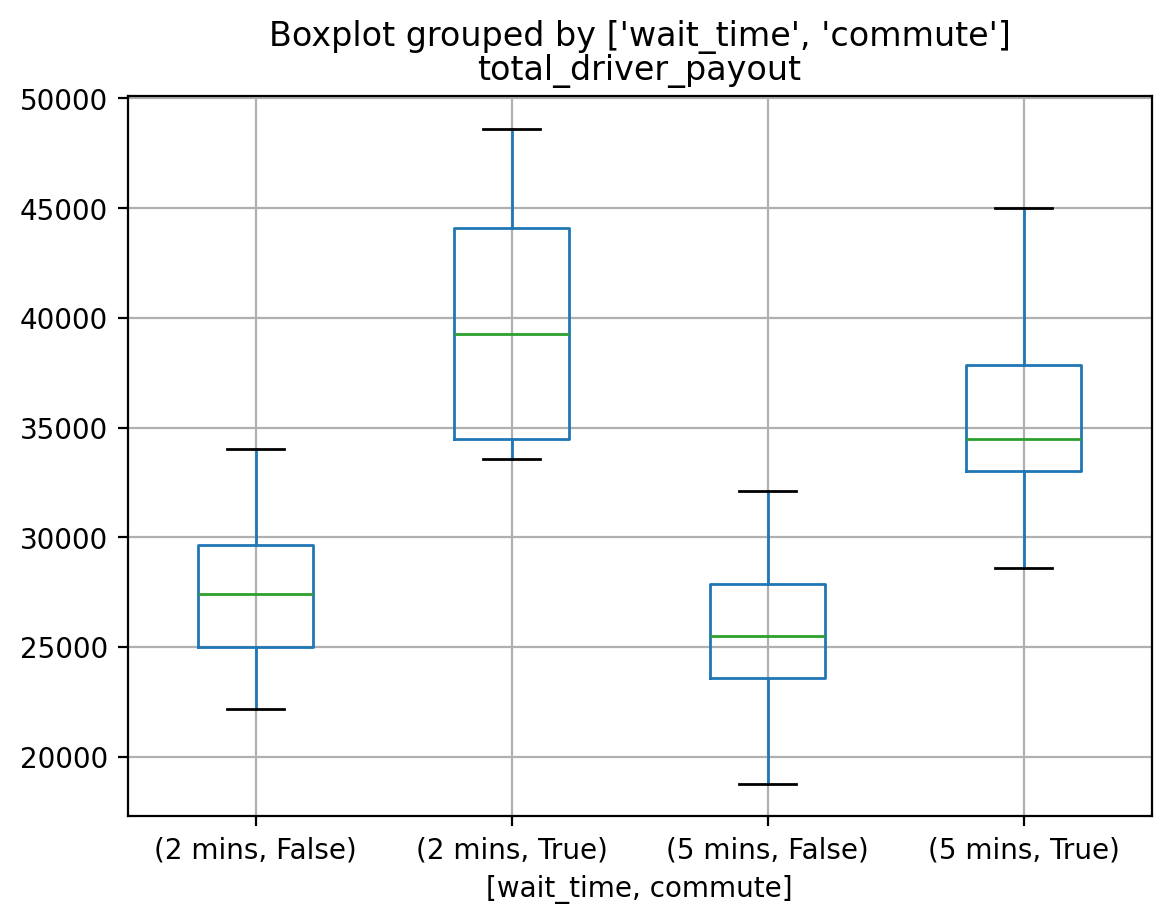

In [72]:
df.boxplot(column='total_driver_payout', by=['wait_time','commute'])

In [69]:
calc_confidence_interval(c, 'total_driver_payout')

CI: 18166.813166055894 to 40415.664677573404


In [70]:
calc_confidence_interval(t, 'total_driver_payout')

CI: 17298.61899927318 to 37067.78578021836


In [68]:
t_stat, p_value = ttest_rel(c['total_driver_payout'], t['total_driver_payout'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.164669942178623, P-value: 0.034271435003953896


<Axes: title={'center': 'trips_pool'}, xlabel='wait_time'>

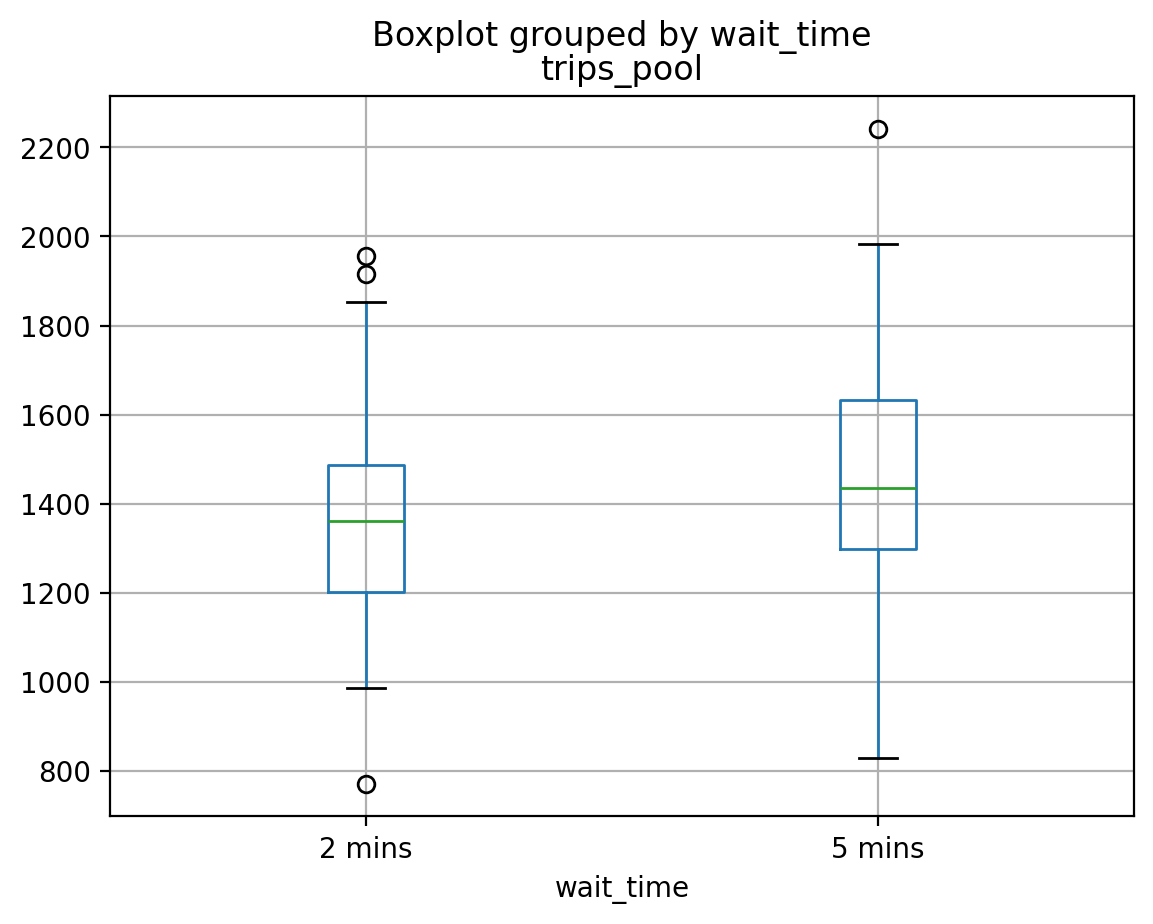

In [63]:
df.boxplot(column='trips_pool', by='wait_time')

<Axes: title={'center': 'trips_express_pool'}, xlabel='wait_time'>

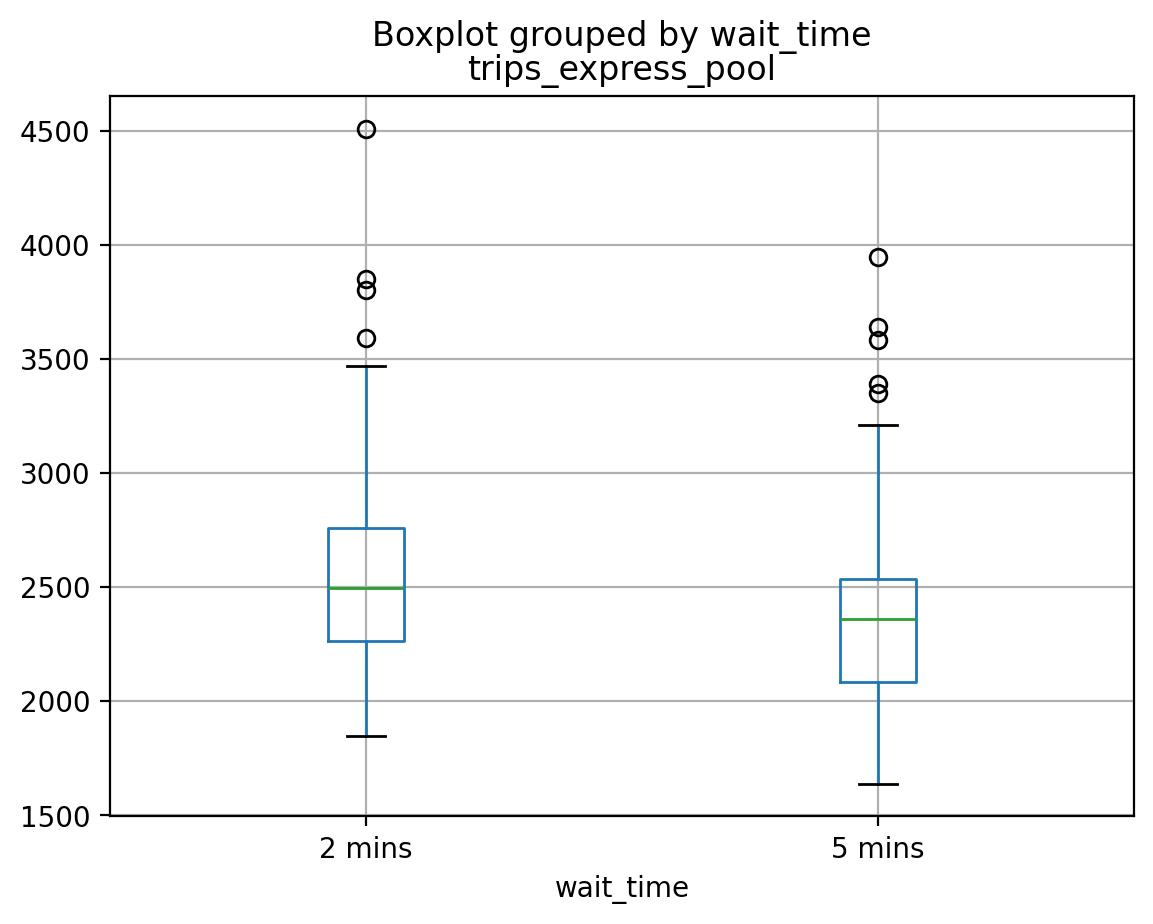

In [64]:
df.boxplot(column='trips_express_pool', by='wait_time')

<Axes: title={'center': 'total_trips'}, xlabel='wait_time'>

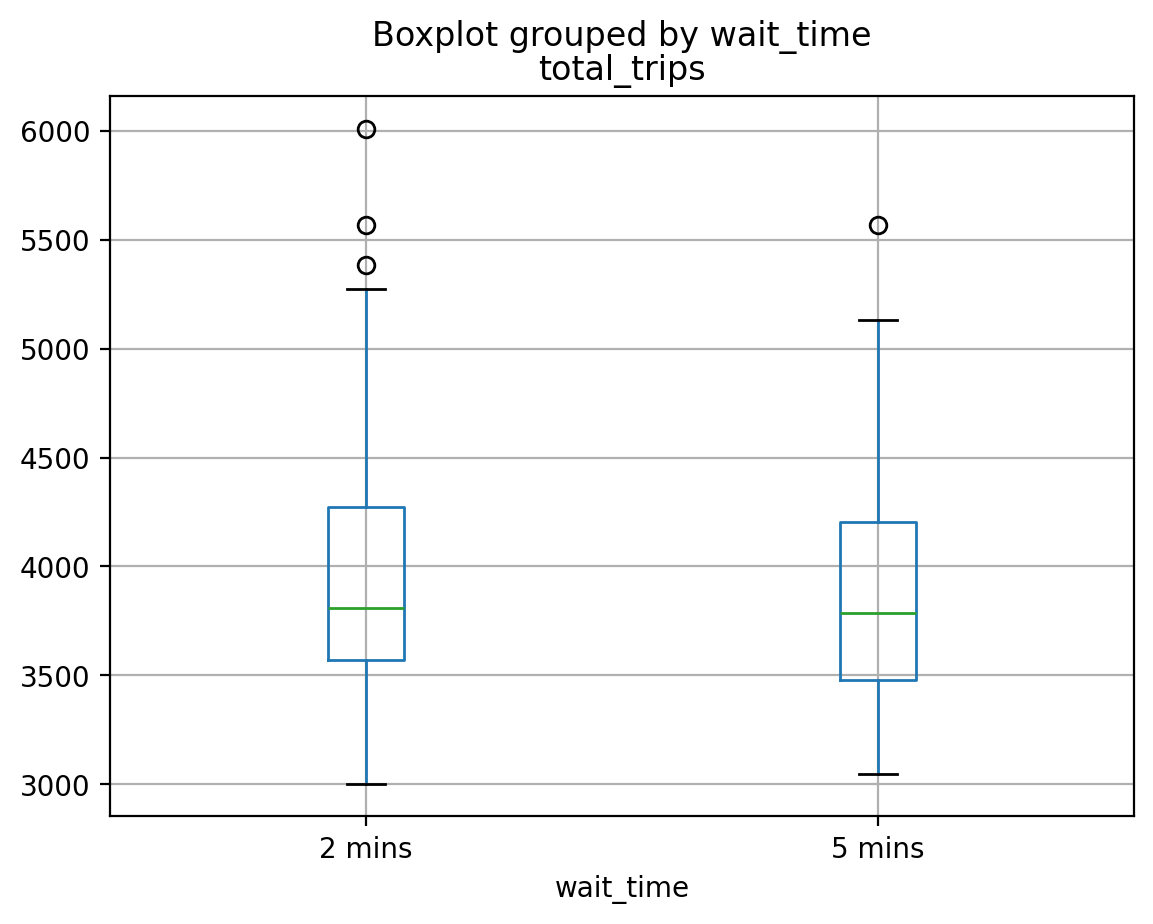

In [65]:
df.boxplot(column='total_trips', by='wait_time')